In [ ]:
!pip install langdetect
!pip install nltk


In [ ]:
import pandas as pd
import numpy as np
import warnings

# data vis
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# NLP
import langdetect
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.stats import pointbiserialr

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline




---

#**Exploratory Data Analysis**

---


In [ ]:
df = pd.read_csv('/content/ebay_reviews_cleaned.csv')
df.head(5)

,Unnamed: 0,rating,review
0,0,1,wireless gaming headset gaming headset ticks ...
1,1,0,good big head low budget easy setup rated 6 ho...
2,2,1,mezumiwireless gaming headset originally bough...
3,3,1,hw s2 great headset 2nd mezumi headset kills f...
4,4,1,best headphones ive purchased entire life prob...


In [121]:
df.isnull().sum()

,0
Unnamed: 0,0
rating,0
review,0
is_english,0
is_reasonable,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45752 entries, 0 to 45751
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45752 non-null  int64 
 1   rating      45752 non-null  int64 
 2   review      45752 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


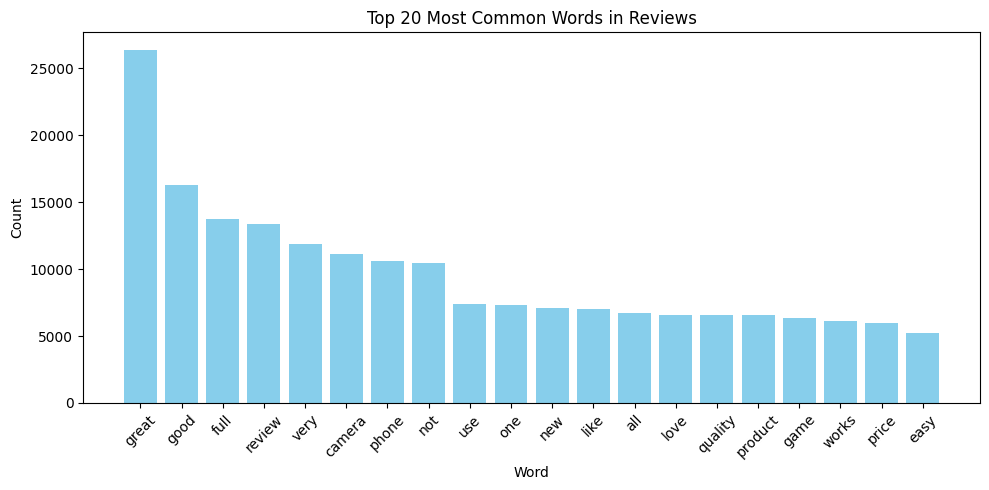

In [123]:
import matplotlib.pyplot as plt

top_words, top_counts = zip(*most_common_words)
plt.figure(figsize=(10, 5))
plt.bar(top_words, top_counts, color='skyblue')
plt.title('Top 20 Most Common Words in Reviews')
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* At the start, we looked at the most common words in the reviews and saw that most of the reviews are written in English. Because of this, we decided to clean the data and keep only English words for our analysis.

---

###FILTER DICTONARY
---

In [107]:
# Check if the text is in English
def is_english(text):
    try:
        return langdetect.detect(text) == 'en'
    except:
        return False

# Check if the review is meaningful (at least two words, each with more than 2 letters, and not repeated)
def is_reasonable(text):
    words = re.findall(r'[a-zA-Z]{3,}', str(text))
    unique_words = set(words)
    return (len(words) >= 2) and (len(unique_words) > 1)

# Filter reviews: keep only English and reasonable ones
df['is_english'] = df['review'].apply(is_english)
df['is_reasonable'] = df['review'].apply(is_reasonable)
df_filtered = df[df['is_english'] & df['is_reasonable']].copy()

# Keep only the columns needed for further analysis
df_result = df_filtered[['rating', 'review']].reset_index(drop=True)

print("Reviews after filtering:", len(df_result))

Reviews after filtering: 42149


* Only English and meaningful reviews are kept for better analysis.

---

###Class Balance

---

Rating distribution:
rating
-1     1876
 0     1379
 1    38894

Rating statistics:
count    42149.000000
mean         0.878265
std          0.442648
min         -1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000


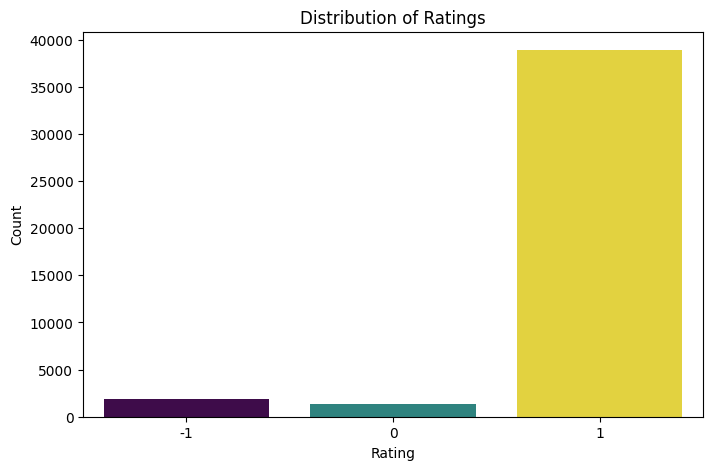

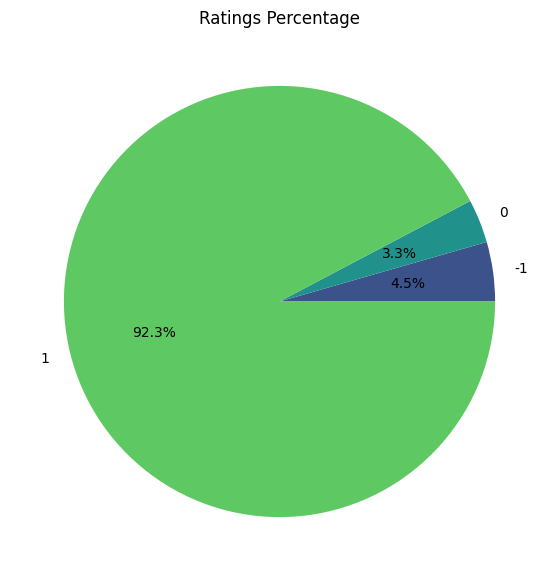

In [108]:
# Check distribution of 'rating' column
rating_counts = df_result['rating'].value_counts().sort_index()

print("Rating distribution:")
print(rating_counts.to_string())  # Cleaner print, no dtype output

# Basic descriptive statistics for rating
rating_stats = df_result['rating'].describe()
print("\nRating statistics:")
print(rating_stats.to_string())  # Cleaner print, no dtype output

# Plot distribution of ratings as bar chart
plt.figure(figsize=(8,5))
sns.countplot(x='rating', data=df_result, hue='rating', palette='viridis', order=sorted(df_result['rating'].unique()), legend=False)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Plot rating distribution as pie chart
plt.figure(figsize=(7,7))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis', len(rating_counts)))
plt.title('Ratings Percentage')
plt.show()

In [118]:
df_result['rating'] = df_result['rating'].replace(-1, 0)

* **Replace -1 ratings with 0 (grouping negative/neutral together)**

In [ ]:
rating_counts = df_result['rating'].value_counts().sort_index()

print("Rating distribution:")
print(rating_counts)

Rating distribution:
rating
0     3259
1    38934
Name: count, dtype: int64


In [ ]:
df_major = df_result[df_result['rating'] == 1]
df_minor = df_result[df_result['rating'] == 0]

df_major_downsampled = df_major.sample(len(df_minor), random_state=42)
df_balanced = pd.concat([df_major_downsampled, df_minor])

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42)

* **The dataset is now balanced: equal positive and negative reviews.**

In [ ]:
rating_counts = df_balanced['rating'].value_counts().sort_index()

print("Rating distribution:")
print(rating_counts)

Rating distribution:
rating
0    3259
1    3259
Name: count, dtype: int64


* **balance**

---

#SEPORATE REVIEWS TO WORDS

---

In [110]:
column_with_reviews = 'review'

# Join all reviews into one string, then split into words (lowercased)
all_text = ' '.join(df_balanced[column_with_reviews].dropna().astype(str))
words = re.findall(r'\b\w+\b', all_text.lower())

# Get the set of unique words
unique_words = set(words)

print(f"Total unique words: {len(unique_words)}")

Total unique words: 16235


In [111]:
# Keep only words that contain only Latin letters and are longer than 2 characters
clean_words = [w for w in unique_words if re.fullmatch(r'[a-zA-Z]{3,}', w)]
print(f"After cleaning: {len(clean_words)} words")

After cleaning: 14548 words


In [114]:
import nltk
import contextlib
import sys
from nltk.corpus import words as nltk_words

# Suppress NLTK download messages
with contextlib.redirect_stdout(sys.__stdout__):
    nltk.download('words', quiet=True)

# Create a set of valid English words from the NLTK corpus
english_vocab = set(w.lower() for w in nltk_words.words())

# Filter out only real English words from the clean word list
real_english_words = [w for w in clean_words if w.lower() in english_vocab]
print(f"After filtering by dictionary: {len(real_english_words)} words")

After filtering by dictionary: 6185 words


---

#One hot encoding
---

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize reviews: each word from real_english_words becomes a column (one-hot encoding)
vectorizer = CountVectorizer(
    binary=True,
    stop_words='english',
    vocabulary=sorted(real_english_words)  # Sort vocabulary alphabetically
)
X = vectorizer.fit_transform(df_balanced['review'].astype(str))

# Build DataFrame from one-hot matrix (rows: reviews, columns: words)
df_onehot_words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Drop columns 'rating' and 'review' if they appear (avoid duplicates)
df_onehot_words = df_onehot_words.drop(columns=[col for col in ['rating', 'review'] if col in df_onehot_words.columns])

# Create final DataFrame: keep 'rating' and 'review', plus one-hot encoded word columns
df_onehot = pd.concat([
    df_balanced[['rating', 'review']].reset_index(drop=True),
    df_onehot_words.reset_index(drop=True)
], axis=1)

In [120]:
df_onehot.head(3)

,rating,review,abandon,aberration,ability,able,abound,abrasive,abroad,absence,...,youth,youve,zebra,zero,zip,zipper,zips,zone,zoning,zoom
0,1,like brand new love awesone note 8 like brand ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,great upgrade love worth amount surprised sma...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,fantastic price damage done casing makes calli...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
dupes = df_onehot.columns[df_onehot.columns.duplicated()]
print("duplicte:", dupes.tolist())

duplicte: []


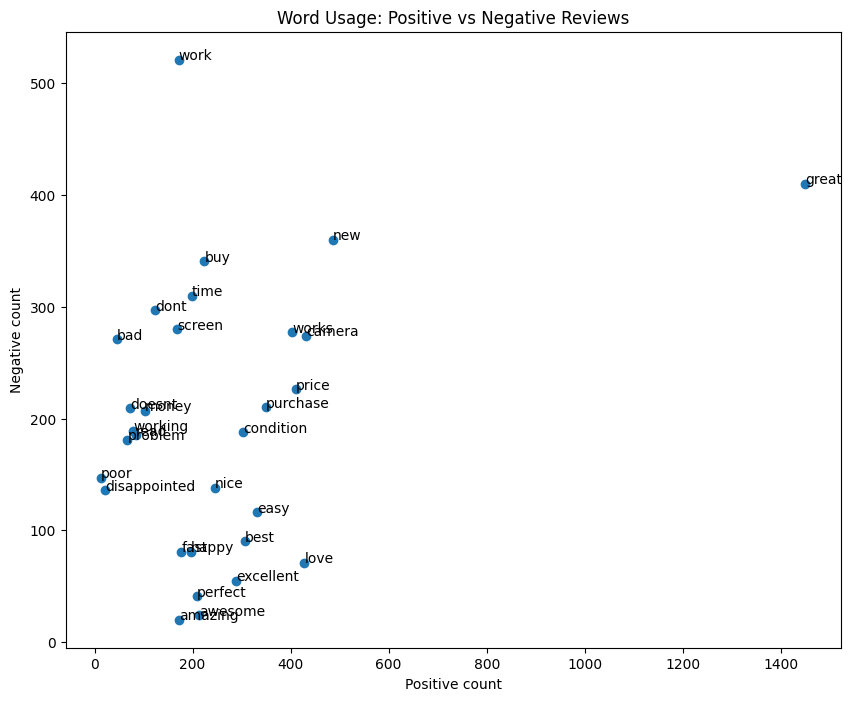

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Split the df_onehot DataFrame into positive and negative reviews
df_pos = df_onehot[df_onehot['rating'] == 1].drop(columns=['rating', 'review'])
df_neg = df_onehot[df_onehot['rating'] == 0].drop(columns=['rating', 'review'])

# Calculate the sum of word occurrences for each rating group
word_freq_pos = df_pos.sum()
word_freq_neg = df_neg.sum()

# Возьмем топ-30 самых "разделяющих" слов (например, наибольшая разница)
top_diff = (word_freq_pos - word_freq_neg).abs().sort_values(ascending=False).head(30).index
plt.figure(figsize=(10, 8))
plt.scatter(word_freq_pos[top_diff], word_freq_neg[top_diff])
plt.xlabel('Positive count')
plt.ylabel('Negative count')
plt.title('Word Usage: Positive vs Negative Reviews')
for word in top_diff:
    plt.annotate(word, (word_freq_pos[word], word_freq_neg[word]))
plt.show()

* **Conclusion**: The word frequency analysis shows that some words clearly separate positive and negative reviews, but there are also neutral or ambiguous words.

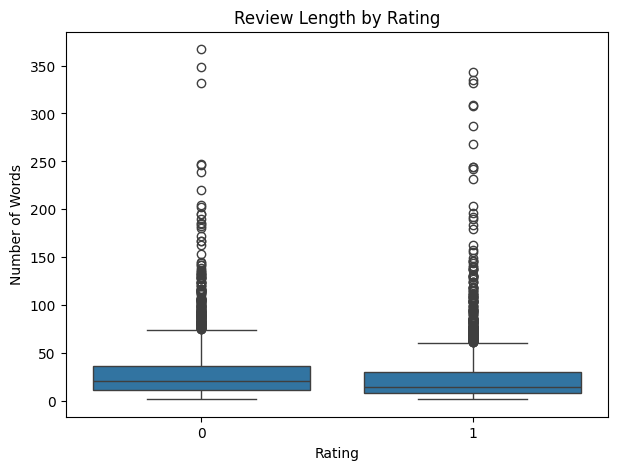

In [ ]:
import seaborn as sns

df_onehot['review_length'] = df_onehot['review'].str.split().apply(len)
plt.figure(figsize=(7, 5))
sns.boxplot(x='rating', y='review_length', data=df_onehot)
plt.title('Review Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Words')
plt.show()

* The average review length does not really help to distinguish positive reviews from negative ones.
If there was a strong difference between the classes, the boxes would be shifted apart from each other.

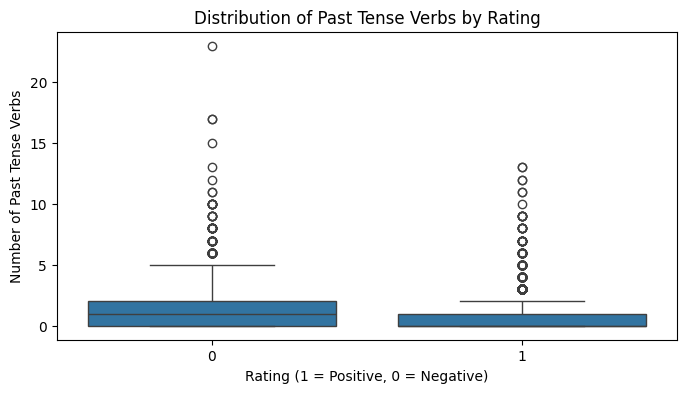

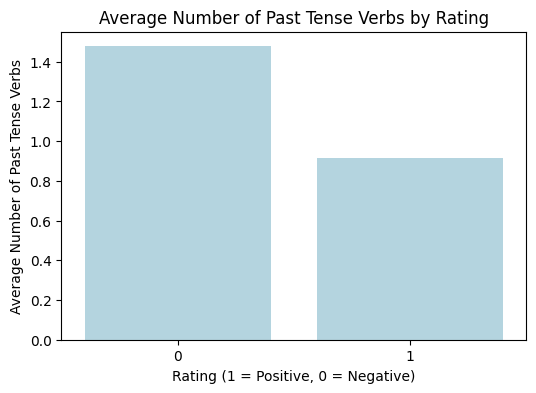

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.boxplot(x='rating', y='past_verbs', data=df_balanced)
plt.title('Distribution of Past Tense Verbs by Rating')
plt.xlabel('Rating (1 = Positive, 0 = Negative)')
plt.ylabel('Number of Past Tense Verbs')
plt.show()

# Среднее значение (barplot)
mean_past_verbs = df_balanced.groupby('rating')['past_verbs'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x='rating', y='past_verbs', data=mean_past_verbs, color='lightblue')
plt.title('Average Number of Past Tense Verbs by Rating')
plt.xlabel('Rating (1 = Positive, 0 = Negative)')
plt.ylabel('Average Number of Past Tense Verbs')
plt.show()

* In negative reviews (rating = 0), there are usually more past tense verbs than in positive reviews (rating = 1).
* This means: negative reviews often describe a bad experience from the past, while positive reviews talk less about the past.
* This feature helps to tell the difference between positive and negative reviews.

# Training the Model on a Balanced Dataset

In [ ]:
X = df_onehot['review']
y = df_onehot['rating']

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5214,) (1304,) (5214,) (1304,)


In [ ]:
#  pipeline: TF-IDF + logistic regresion
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=10000)),
    ('clf', LogisticRegression(max_iter=1000))
])

# learn model
pipeline.fit(X_train, y_train)

# pred
y_pred = pipeline.predict(X_test)

# metrics
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[569  83]
 [ 86 566]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       652
           1       0.87      0.87      0.87       652

    accuracy                           0.87      1304
   macro avg       0.87      0.87      0.87      1304
weighted avg       0.87      0.87      0.87      1304



# Interpreting the Model: Most Informative Words

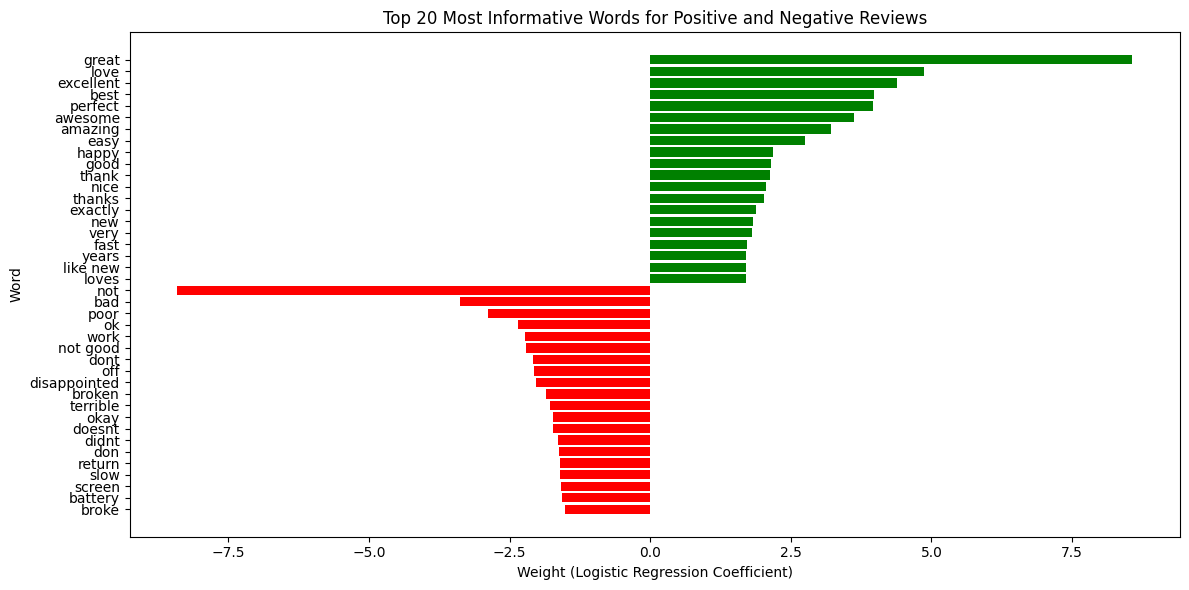

In [ ]:
# Extract trained vectorizer and model from the pipeline
vectorizer = pipeline.named_steps['tfidf']
classifier = pipeline.named_steps['clf']

# Get list of words and corresponding weights (coefficients)
feature_names = vectorizer.get_feature_names_out()
coefficients = classifier.coef_[0]  # only one class, take the first (binary classification)

# Build a DataFrame with words and their weights
weights_df = pd.DataFrame({
    'word': feature_names,
    'weight': coefficients
})

# Sort by weight (importance)
top_positive = weights_df.sort_values(by='weight', ascending=False).head(20)
top_negative = weights_df.sort_values(by='weight').head(20)  # most negative at the top

# Combine for plotting
top_combined = pd.concat([top_positive, top_negative])

# Visualization: horizontal bar chart
plt.figure(figsize=(12, 6))
colors = ['green' if w > 0 else 'red' for w in top_combined['weight']]
plt.barh(top_combined['word'], top_combined['weight'], color=colors)
plt.title("Top 20 Most Informative Words for Positive and Negative Reviews")
plt.xlabel("Weight (Logistic Regression Coefficient)")
plt.ylabel("Word")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Exporting the Model Pipeline to a .pkl File

In [ ]:
import joblib

# Сохраняем весь pipeline: TF-IDF + LogisticRegression
joblib.dump(pipeline, 'review_model.pkl')

print("✅ Model saved to 'review_model.pkl'")

✅ Model saved to 'review_model.pkl'
